<h1> Assignment 3: Group Project </h1>

In [1]:
# import libraries

import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import re

# 1. Data preparation and exploration

## 1.1 Data Retrieving

In [2]:
movies_df = pd.read_csv('data/movies.csv', delimiter=',')
ratings_df = pd.read_csv('data/ratings.csv', delimiter=',')

C:\Users\paull\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
movies_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [4]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


## 1.2 Data cleaning and preparation

In [5]:
# Create orginal data frame for backup
movies_df_raw = movies_df.copy()
ratings_df_raw = ratings_df.copy()

In [6]:
#set threshold
threshold = 0.65

# dropping columns with missing value rate higher than threshold
ratings_df = ratings_df[ratings_df.columns[ratings_df.isnull().mean() < threshold]]

# Remove the missing values from the rows having greater or equal to 6 missing values.
movies_df = movies_df[movies_df.isnull().sum(axis=1) <= 6]
ratings_df = ratings_df[ratings_df.isnull().sum(axis=1) <= 6]

### 1.2.1 Handle missing data

In [7]:
# Percentage of missing value in movies_df before cleaning
percent_missing = movies_df.isnull().sum() * 100 / len(movies_df)
missing_values = pd.DataFrame({'percent_missing': percent_missing})
missing_values.sort_values(by ='percent_missing' , ascending=False)

,percent_missing
belongs_to_collection,90.121447
homepage,82.887442
tagline,55.091085
overview,2.081317
poster_path,0.825046
runtime,0.547831
status,0.178210
release_date,0.169409
imdb_id,0.035202
original_language,0.024201


In [8]:
# Filling missing value for movies dataset

movies_df["tagline"] = movies_df["tagline"].fillna("Unknown")

movies_df["overview"] = movies_df["overview"].fillna("Unknown")

movies_df["poster_path"] = movies_df["poster_path"].fillna("Unknown")

movies_df["runtime"] = movies_df["runtime"].fillna(method='ffill')

movies_df["release_date"] = movies_df["release_date"].fillna(method='ffill')

movies_df["status"] = movies_df["status"].fillna(movies_df['status'].mode()[0])

movies_df["imdb_id"] = movies_df["imdb_id"].fillna(method='ffill')

movies_df["original_language"] = movies_df["original_language"].fillna(movies_df['original_language'].mode()[0])

In [9]:
# Percentage of missing value in movies_df after cleaning
percent_missing = movies_df.isnull().sum() * 100 / len(movies_df)
missing_values = pd.DataFrame({'percent_missing': percent_missing})
missing_values.sort_values(by ='percent_missing' , ascending=False)

,percent_missing
belongs_to_collection,90.121447
homepage,82.887442
adult,0.000000
production_countries,0.000000
vote_average,0.000000
video,0.000000
title,0.000000
tagline,0.000000
status,0.000000
spoken_languages,0.000000


In [10]:
# Percentage of missing value in ratings_df before cleaning
percent_missing = ratings_df.isnull().sum() * 100 / len(ratings_df)
missing_values = pd.DataFrame({'percent_missing': percent_missing})
missing_values.sort_values(by ='percent_missing' , ascending=False)

,percent_missing
userId,0.0
movieId,0.0
rating,0.0
timestamp,0.0


In [11]:
# rename column id in movies_df to match movieId with ratings_df
movies_df.rename(columns={"id": "movieId"}, inplace=True)

In [12]:
# Check type for movies_df
movies_df.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
movieId                   object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [13]:
# Check type for ratings_df
ratings_df.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [14]:
# Delete row in movieId column contain string value
movies_df = movies_df[~movies_df['movieId'].isin(['1997-08-20', '2012-09-29','2014-01-01'])]

In [15]:
# change column type for movies_df
movies_df["movieId"] = movies_df['movieId'].astype(float)

movies_df['popularity'] = movies_df['popularity'].astype(float)

movies_df['budget'] = movies_df['budget'].astype(float)

Each movie has many ratings rated by many different users. We calculate the average ratings of one movie by sum all the ratings of one movie and divide by the number of ratings.

In [16]:
ratings_df = ratings_df.groupby(['movieId']).mean().groupby('movieId')['rating'].mean().reset_index()

In [17]:
df = movies_df.merge(ratings_df, how="left", on="movieId")

comment_counts = pd.DataFrame(df["title"].value_counts())
rare_movies = comment_counts[comment_counts["title"] <= 1000].index
common_movies = df[~df["title"].isin(rare_movies)]
# round rating float, for classification
df = df.round({'rating': 0})

In [18]:
df['rating'].isnull().sum()

37418

As you can see, there are too many missing values in the rating column. With this missing data, we cannot do much to clean the data. Since if fill data in the missing value, the data will be biased and cause the result of the model to be wrong.

In the dataset, there are some columns with array object as values. We would like to convert to array string based on the field name

In [19]:
from ast import literal_eval

def split_genres(row):
    row['genres'] = ",".join([info['name'] for info in literal_eval(row['genres'])])
    return row

def split_prod_countries(row):
    row['production_countries'] = ",".join([info['name'] for info in literal_eval(row['production_countries'])])
    return row

def split_prod_companies(row):
    row['production_companies'] = ",".join([info['name'] for info in literal_eval(row['production_companies'])])
    return row

def split_spoken_languages(row):
    row['spoken_languages'] = ",".join([info['name'] for info in literal_eval(row['spoken_languages'])])
    return row
  
df = df.apply(split_genres, axis=1)
df = df.apply(split_prod_countries, axis=1)
df = df.apply(split_prod_companies, axis=1)
df = df.apply(split_spoken_languages, axis=1)

In [20]:
# function for text cleaning
def clean_text(text):
    # remove backslash-apostrophe
    text = re.sub("\'", "", text)
    # remove everything alphabets
    text = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    # remove whitespaces
    text = ' '.join(text.split())
    # remove double whote inside
    text = text.replace('“', '').replace('”', '').replace('"', '')
    # remove number
    text = re.sub(r"\d+", "", text)
    # convert text to lowercase
    text = text.lower()
    
    return text

In [21]:
# Apply clean_text function for cleaning text
df['title'] = df['title'].apply(lambda x: clean_text(x))
df['tagline'] = df['tagline'].apply(lambda x: clean_text(x))
df['original_title'] = df['original_title'].apply(lambda x: clean_text(x))
df['overview'] = df['overview'].apply(lambda x: clean_text(x))

In [22]:
# Remove stopword
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)
  
df['overview'] = df['overview'].apply(lambda x: remove_stopwords(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\paull\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1.3 Data Exploration

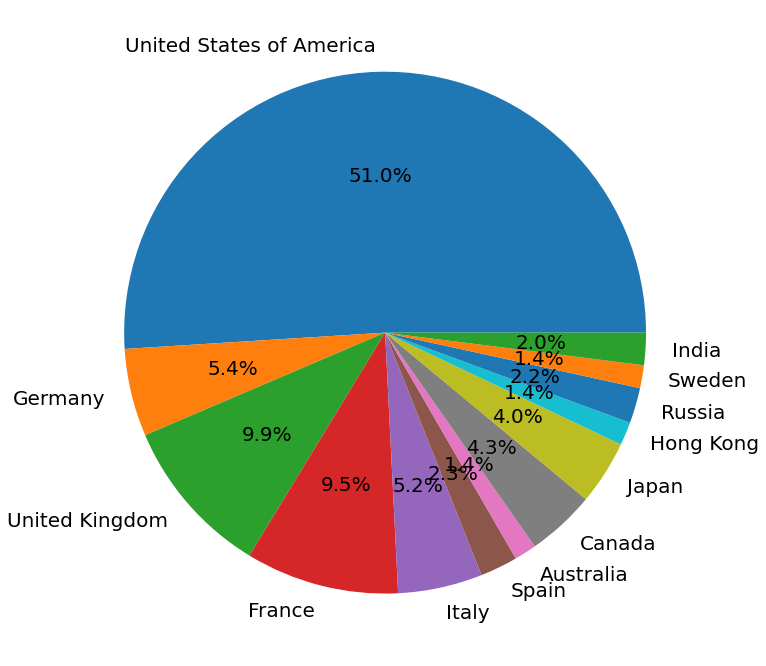

In [23]:
from collections import Counter

a=[]
for each in df.production_countries.str.split(","):
    for i in each:
        a.append(i)
        
b = dict(Counter(a))

keys=[]
values=[]

for key,value in b.items() :
    if value > 500 and key != "":
        keys.append(key)
        values.append(value)

       
labels = keys
colors = sns.color_palette()
explode =[0,0,0,0,0,0,0,0,0,0,0,0,0]
sizes= values
    
plt.figure(figsize = (20,12))

plt.pie(sizes,explode = explode,labels=labels,colors = colors,autopct='%1.1f%%',textprops= {"fontsize": 20},shadow = False)

plt.show()

Text(0.5, 1.0, 'Number of movie types')

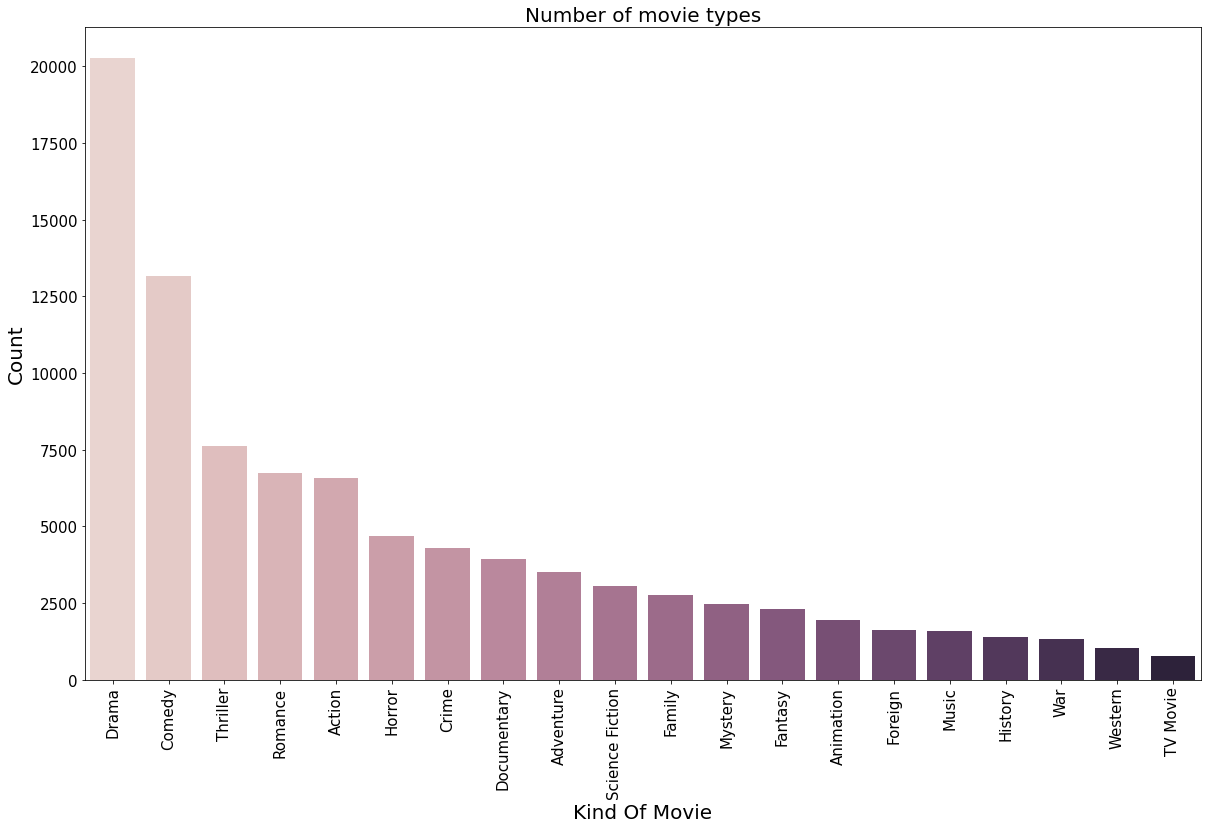

In [24]:
from collections import Counter

data = df.genres.copy()

list_kind = data.str.split(",")
a = []
for each in list_kind:
    for i in each:
        a.append(i)
        
c=[]
for each in a:
    if each != "":
         c.append(each)        
        
f= dict(Counter(c))

df3 = pd.DataFrame(list(f.items()),columns = ["kind","ratio"])
new_index =( df3.ratio.sort_values(ascending=False)).index.values
new = df3.reindex(new_index)

plt.figure( figsize = (20,12))
plt.tick_params(labelsize = 15)
sns.barplot(x="kind",y="ratio",data=new,palette = sns.cubehelix_palette(len(f)))
plt.xticks(rotation = 90)
plt.xlabel("Kind Of Movie",fontsize=20)
plt.ylabel("Count",fontsize=20)
plt.title("Number of movie types",fontsize = 20)

C:\Users\paull\AppData\Local\Temp/ipykernel_4092/2533671194.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([num for num in ax.get_yticks()])


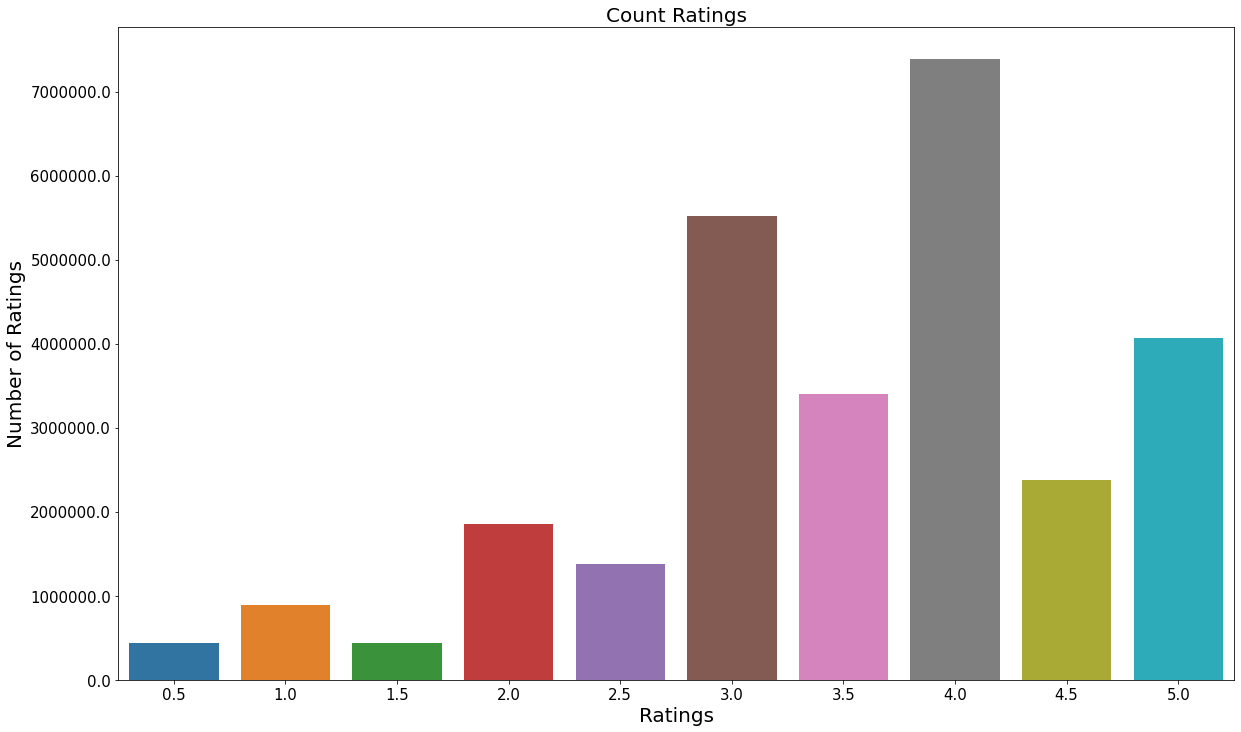

In [25]:
f,ax = plt.subplots(1,1,figsize=(20,12))
ax = sns.countplot(x="rating", data=ratings_df_raw)
ax.set_yticklabels([num for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Count Ratings", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

In [26]:
df['status'].value_counts()

Released           45087
Rumored              230
Post Production       98
In Production         20
Planned               15
Canceled               2
Name: status, dtype: int64

Text(0.5, 1.0, 'Popular Movies')

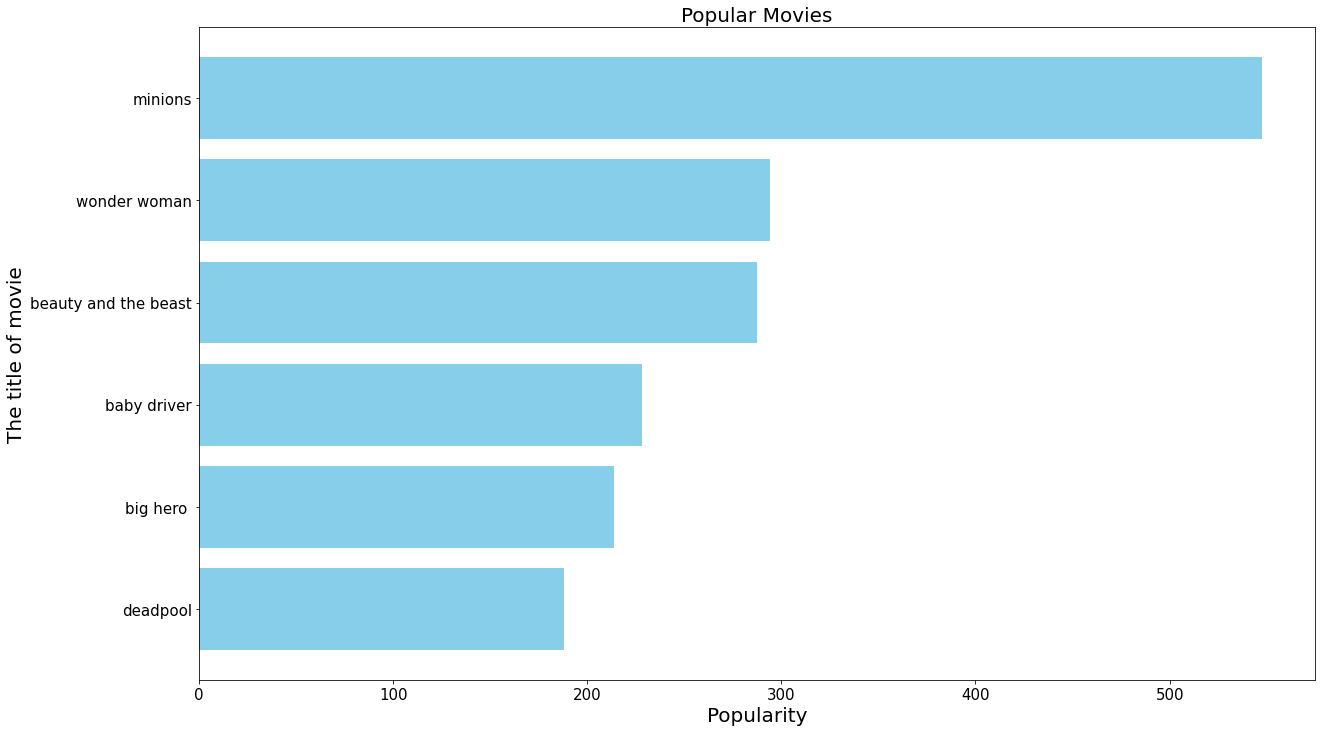

In [27]:
pop = df.sort_values('popularity', ascending=False)
plt.figure(figsize=(20,12))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.tick_params(labelsize = 15)
plt.xlabel("Popularity", fontsize = 20)
plt.ylabel("The title of movie", fontsize = 20)
plt.title("Popular Movies", fontsize = 20)

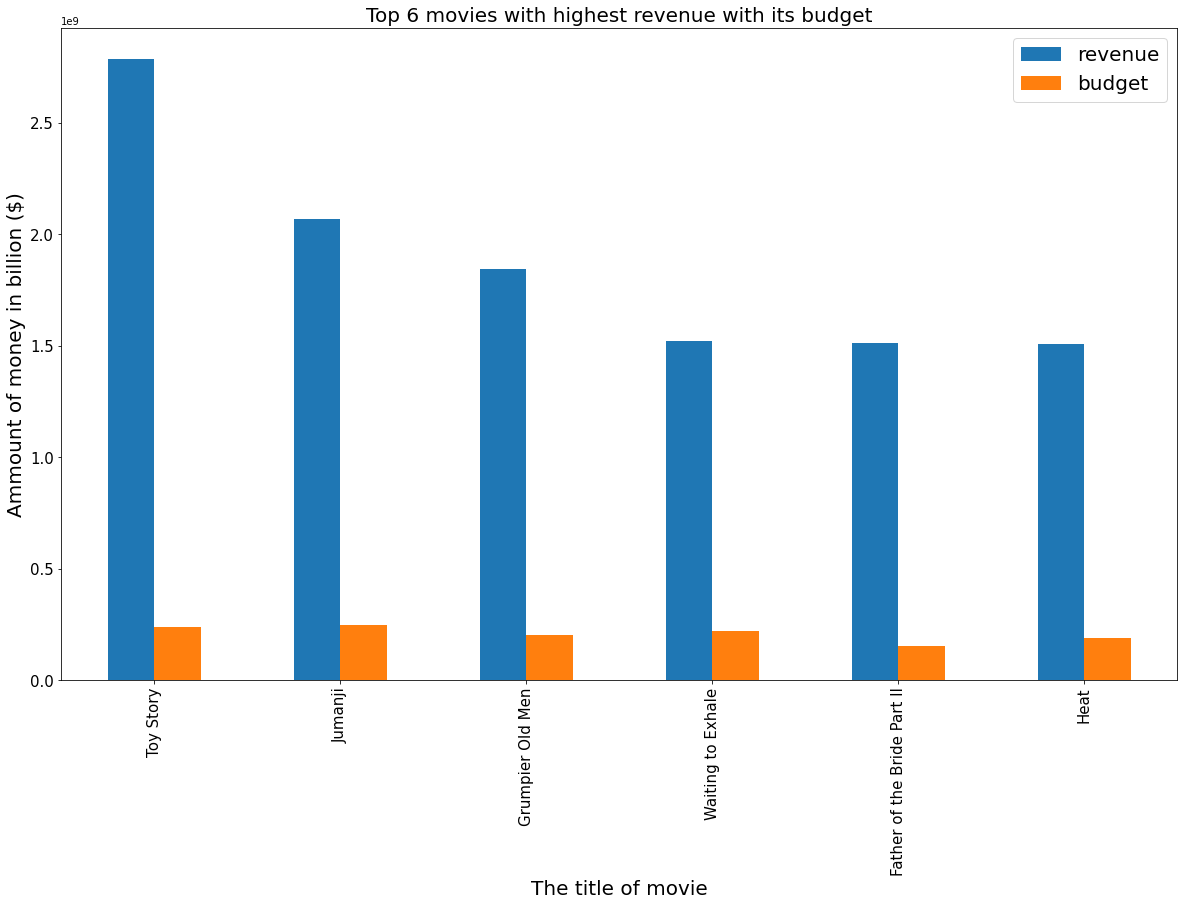

In [28]:
df1 = movies_df[['title','revenue','budget']].copy()

df1.set_index('title', inplace=True)

ax = df1.sort_values(by=['revenue'], ascending=False).head(6).plot(kind='bar', figsize=(20,12))
ax.xaxis.set_major_formatter(plt.FixedFormatter(df1.index.to_series()))
plt.tick_params(labelsize = 15)
plt.ylabel("Ammount of money in billion ($)", fontsize = 20)
plt.xlabel("The title of movie", fontsize = 20)
plt.legend(fontsize=20)
plt.title("Top 6 movies with highest revenue with its budget", fontsize = 20)
plt.show()

Text(0.5, 1.0, 'Most popular language in movies')

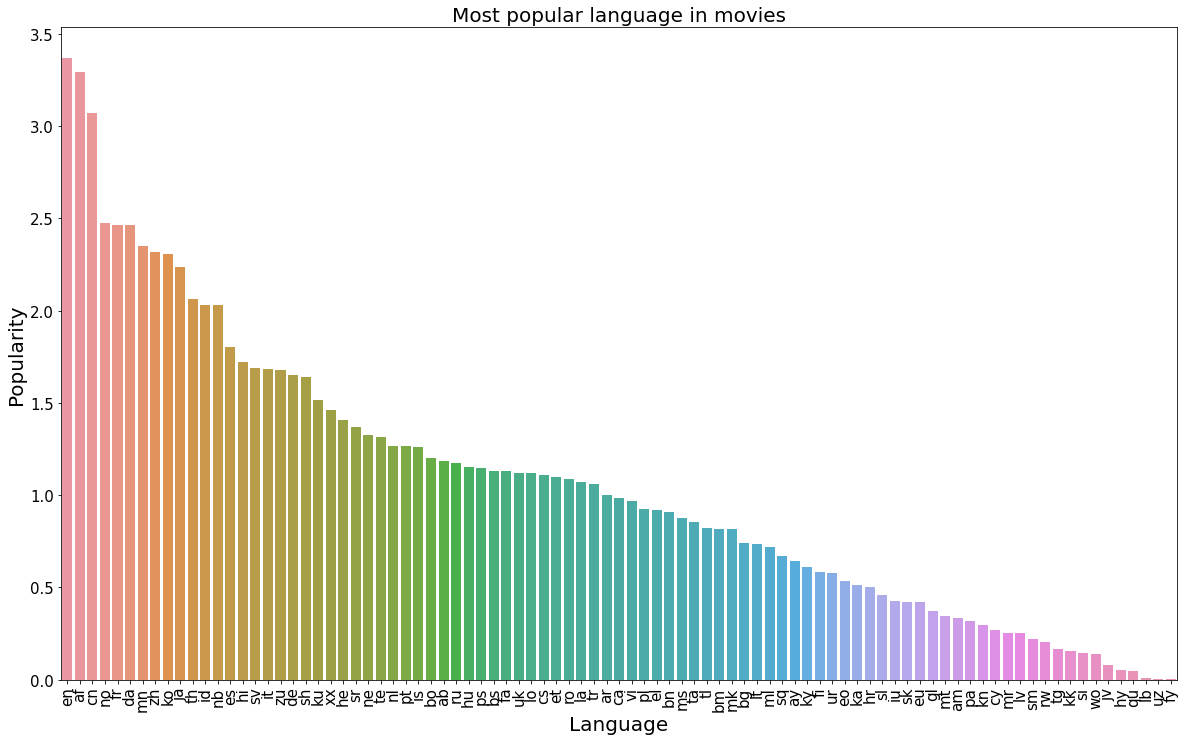

In [29]:
unique = list(movies_df.original_language.unique())
list_ratio=[]
for each in unique:
    x= movies_df[movies_df["original_language"] == each]
    ratio_popularity=sum(x.popularity)/len(x)
    list_ratio.append(ratio_popularity)
    
df1 = pd.DataFrame({"language":unique,"ratio":list_ratio})
new_index = (df1.ratio.sort_values(ascending = False)).index.values
sorted_data= df1.reindex(new_index)

#Visualization
plt.figure(figsize = (20,12))
sns.barplot(x= sorted_data["language"],y  = sorted_data["ratio"])
plt.xticks(rotation= 90)
plt.tick_params(labelsize = 15)

plt.xlabel("Language",fontsize = 20)
plt.ylabel("Popularity",fontsize = 20)
plt.title("Most popular language in movies", fontsize = 20)

# 2. Data Modelling
---

## Categorical Encoding

**belongs_to_collection**


Convert column 'belongs_to_collection' data to binary data of 0 and 1 (1 means the movie belongs to a collection, and 0 means it does not belong to any collection).

In [30]:
# converting column 'belongs_to_collection' to binary 0 and 1 data
df["belongs_to_collection"] = df["belongs_to_collection"].fillna(0)
df["belongs_to_collection"] = np.where(df["belongs_to_collection"] != 0,1,0)
df['belongs_to_collection'] = pd.to_numeric(df['belongs_to_collection'])

**homepage**

Convert column 'homepage' to binary data of 0 and 1 (1 means the movie has a homepage, and 0 means the movie does not have a homepage)

In [31]:
df["homepage"] = df["homepage"].fillna(0)
df["homepage"] = np.where(df["homepage"] != 0,1,0)
df['homepage'] = pd.to_numeric(df['homepage'])

**adult**

Convert column 'adult' data from boolean value to 1 and 0 (1: True, 0: False)

In [32]:
df["adult"] = np.where(df['adult'] == True, 1, 0)
df['adult'] = pd.to_numeric(df['adult'])

**video**

Convert column 'video' data from boolean value to 1 and 0 (1: True, 0: False)

In [33]:
df["video"] = np.where(df['video'] == True, 1, 0)
df['video'] = pd.to_numeric(df['video'])

**status**

In [34]:
df['status'].value_counts()

Released           45087
Rumored              230
Post Production       98
In Production         20
Planned               15
Canceled               2
Name: status, dtype: int64

Since "Released" is the dominant value in this column, we can make the dataset easier for computing by replacing value "Released" with 1, and the others with 0.

In [35]:
df["status"] = np.where(df['status'] == True, 1, 0)
df['status'] = pd.to_numeric(df['status'])

**spoken_languages**

In [36]:
df['spoken_languages'].value_counts()

English                           22395
                                   3945
Français                           1852
日本語                                1289
Italiano                           1218
                                  ...  
Deutsch,,ελληνικά,English             1
English,suomi,Deutsch,svenska         1
English,Français,Deutsch,فارسی        1
svenska,English,Español               1
Fulfulde,English                      1
Name: spoken_languages, Length: 1842, dtype: int64

Same with column 'status', English is the most common language used in the movies. In addition, it also dominate other languages in terms of quantity. Therefore, we can set value 1 for movies that has English as one of the spoken language, and 0 when the movie does not use English.

In [37]:
df["spoken_languages"] = np.where(df['spoken_languages'].str.contains("English"), 1, 0)
df['spoken_languages'] = pd.to_numeric(df['spoken_languages'])

**original_language**

In [38]:
df['original_language'].value_counts()

en    32278
fr     2437
it     1529
ja     1349
de     1078
      ...  
ay        1
rw        1
cy        1
tg        1
si        1
Name: original_language, Length: 89, dtype: int64

In [39]:
df["original_language"] = np.where(df['original_language'] == "en", 1, 0)
df['original_language'] = pd.to_numeric(df['original_language'])

**production_countries**

In [40]:
df['production_countries'].value_counts()

United States of America                  17851
                                           6276
United Kingdom                             2238
France                                     1653
Japan                                      1356
                                          ...  
Romania,United Kingdom,Canada                 1
Finland,Germany,Netherlands                   1
France,Denmark,Spain,Sweden                   1
France,United States of America,Canada        1
Egypt,Italy,United States of America          1
Name: production_countries, Length: 2390, dtype: int64

From a real world perspective, we can observe that the US's movie industry is gigantic. From this standpoint, we can set value of 1 for movies that involved the US in the production phase, and 0 for ther others.

In [41]:
df["production_countries"] = np.where(df['production_countries'].str.contains("United States of America"), 1, 0)
df['production_countries'] = pd.to_numeric(df['production_countries'])

**genres**

In [42]:
genre_list = []
for value in df['genres'].unique():
  value_list = value.split(',')
  for item in value_list:
    genre_list.append(item)

genre_list = np.unique(np.array(genre_list)).tolist()
genre_list.remove("")

for genre in genre_list:
  column_name = 'genres_' + genre
  df[column_name] = np.where(df['genres'].str.contains(genre), 1, 0)
    
df.drop("genres",axis=1,inplace=True)

**production_companies**

In [43]:
df['production_companies'].value_counts()

                                                                                                                                              11868
Metro-Goldwyn-Mayer (MGM)                                                                                                                       742
Warner Bros.                                                                                                                                    540
Paramount Pictures                                                                                                                              505
Twentieth Century Fox Film Corporation                                                                                                          439
                                                                                                                                              ...  
BIM Distribuzione,Canal+,Alta Producción,Centre National de la Cinématographie (CNC),Rézo Productions,Compagnie 

In [44]:
company_list = []
for value in df['production_companies'].unique():
  value_list = value.split(',')
  for item in value_list:
    company_list.append(item)

company_list = np.unique(np.array(company_list)).tolist()
company_list.remove("")
print(len(company_list))

23574


Column 'comnpany_list' has 23574 different companies. Therefore, it would create the same amount of new features if we decide to perform one-hot encoding for this feature.

Interstingly, from the unique value counting, we can observe that value 'Metro-Goldwyn-Mayer (MGM)' appears a lot more frequent than other values of the feature.

**release_date**

To use a datetime feature for fitting into a machine learning model, we can extract cyclical features (day, month) and encode them using sine and cosine transformation. This is to ensure that the data still keeps there cyclinal nature.
https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning

In [45]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [46]:
df['release_date']= pd.to_datetime(df['release_date'])
df['month'] = df.release_date.dt.month
df['day'] = df.release_date.dt.dayofyear

print(df['day'])

0        303
1        349
2        356
3        356
4         41
        ... 
45447    133
45448    321
45449    213
45450    294
45451    160
Name: day, Length: 45452, dtype: int64


In [47]:
df = encode(df, 'month', 12)
df = encode(df, 'day', 365)
# drop original unencoded features
df.drop(['month', 'day', 'release_date'],axis=1,inplace=True)

## 2.1 Feature Engineering

Feature selection for fitting into the machine learning algorithms

In [48]:
df.head()

,adult,belongs_to_collection,budget,homepage,movieId,imdb_id,original_language,original_title,overview,popularity,...,genres_Romance,genres_Science Fiction,genres_TV Movie,genres_Thriller,genres_War,genres_Western,month_sin,month_cos,day_sin,day_cos
0,0,1,30000000.0,1,862.0,tt0114709,1,toy story,led woody andys toys live happily room andys b...,21.946943,...,0,0,0,0,0,0,-8.660254e-01,0.5,-0.875892,0.482508
1,0,0,65000000.0,0,8844.0,tt0113497,1,jumanji,siblings judy peter discover enchanted board g...,17.015539,...,0,0,0,0,0,0,-2.449294e-16,1.0,-0.271958,0.962309
2,0,1,0.0,0,15602.0,tt0113228,1,grumpier old men,family wedding reignites ancient feud nextdoor...,11.712900,...,1,0,0,0,0,0,-2.449294e-16,1.0,-0.154309,0.988023
3,0,0,16000000.0,0,31357.0,tt0114885,1,waiting to exhale,cheated mistreated stepped women holding breat...,3.859495,...,1,0,0,0,0,0,-2.449294e-16,1.0,-0.154309,0.988023
4,0,1,0.0,0,11862.0,tt0113041,1,father of the bride part ii,george banks recovered daughters wedding recei...,8.387519,...,0,0,0,0,0,0,8.660254e-01,0.5,0.648630,0.761104


#### 2.1.1 Reasoning

In [49]:
df['adult'].value_counts()

0    45452
Name: adult, dtype: int64

Because column 'adult' only contains 1 value (False), we can remove this feature from the dataset. Also, from a reality perspective, we can also drop other columns that does not predict the rating of a movies:
- imdb_id: id of the movie on imdb film review site
- movieId: id of the movie in the dataset
- poster_path: url to the poster of the movie
- original_title, title: name of the movie before and after release
- overview: a brief description about the movie
- tagline: the movie quote (usually in posters)

In [50]:
df.drop(['adult','imdb_id','poster_path','title','original_title','overview','movieId','tagline'], axis=1, inplace=True)

In [51]:
first_column = df.pop('rating')
df.insert(0, 'rating', first_column)
df.head()

,rating,belongs_to_collection,budget,homepage,original_language,popularity,production_companies,production_countries,revenue,runtime,...,genres_Romance,genres_Science Fiction,genres_TV Movie,genres_Thriller,genres_War,genres_Western,month_sin,month_cos,day_sin,day_cos
0,4.0,1,30000000.0,1,1,21.946943,Pixar Animation Studios,1,373554033.0,81.0,...,0,0,0,0,0,0,-8.660254e-01,0.5,-0.875892,0.482508
1,4.0,0,65000000.0,0,1,17.015539,"TriStar Pictures,Teitler Film,Interscope Commu...",1,262797249.0,104.0,...,0,0,0,0,0,0,-2.449294e-16,1.0,-0.271958,0.962309
2,NaN,1,0.0,0,1,11.712900,"Warner Bros.,Lancaster Gate",1,0.0,101.0,...,1,0,0,0,0,0,-2.449294e-16,1.0,-0.154309,0.988023
3,NaN,0,16000000.0,0,1,3.859495,Twentieth Century Fox Film Corporation,1,81452156.0,127.0,...,1,0,0,0,0,0,-2.449294e-16,1.0,-0.154309,0.988023
4,NaN,1,0.0,0,1,8.387519,"Sandollar Productions,Touchstone Pictures",1,76578911.0,106.0,...,0,0,0,0,0,0,8.660254e-01,0.5,0.648630,0.761104


In [52]:
df['rating'].value_counts()

3.0    4311
4.0    2482
2.0    1088
1.0     100
5.0      27
0.0      26
Name: rating, dtype: int64

Chi square

In [53]:
from sklearn.feature_selection import chi2

X = df.drop('rating',axis=1)
Y = df['rating']
chi_scores = chi2(X,Y)
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)
p_values.plot.bar()

ValueError: could not convert string to float: 'Pixar Animation Studios'

#### 2.1.2 Correlation Matrix

In [ ]:
f,ax = plt.subplots(figsize = (20,12))
sns.heatmap (df.corr(), annot = True,linewidths =0.75,linecolor = "White",fmt = ".2f",ax = ax,center = -0.1)
plt.show()

### 2.2 K-fold cross validation

In [ ]:
from sklearn.model_selection import KFold

kf5 = KFold(n_splits=5, shuffle=False)

### 2.3 Parameter tuning

### 2.4 Model training

### 2.5 Model Evaluation and Selection

### 2.6 Save the model for deployment

In this task, we use Pickle to save and load the model. Since in order to use the model outside of the notebook, we need to sae it - and then later, we can load and use it for deployment 

In [ ]:
import pickle

# pickle.dump(model1, open('model1.pkl', 'wb'))
# pickle.dump(model2, open('model2.pkl', 'wb'))
# pickle.dump(model3, open('model3.pkl', 'wb'))

## 3. Model deployment and Automation

## 4. Visualisation Dashboard